In [0]:
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass

In [41]:
import tensorflow as tf
tf.__version__

'2.1.0-rc1'

In [42]:
tf.test.is_gpu_available()

True

In [0]:
TRAIN_DATA_URL = "https://drive.google.com/uc?authuser=0&id=11uwGt8fNyHm5VJbmZU6BVhJja7gjQZVQ&export=download"
TEST_DATA_URL = "https://drive.google.com/uc?authuser=0&id=1oTfHdPxVShJOpJ8wbCP0VmymyE9m5iOf&export=download"
SUB_MISSION_URL = "https://drive.google.com/a/dacon.io/uc?authuser=0&id=1jti3rkMN-Tb_WLOIeGVVFDYd_rfE9TFe&export=download"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)
submission_path = tf.keras.utils.get_file("submission_sample.csv", SUB_MISSION_URL)

In [44]:
print(train_file_path)
print(test_file_path)
print(submission_path)

/root/.keras/datasets/train.csv
/root/.keras/datasets/eval.csv
/root/.keras/datasets/submission_sample.csv


In [0]:
import pandas as pd
train = pd.read_csv(train_file_path)

In [46]:
train.head()

id        date  bus_route_id  ... 10~11_takeoff  11~12_takeoff 18~20_ride
0   0  2019-09-01       4270000  ...           0.0            0.0        0.0
1   1  2019-09-01       4270000  ...           0.0            0.0        5.0
2   2  2019-09-01       4270000  ...           0.0            0.0        2.0
3   3  2019-09-01       4270000  ...           0.0            0.0       53.0
4   4  2019-09-01       4270000  ...           0.0            0.0        0.0

[5 rows x 21 columns]

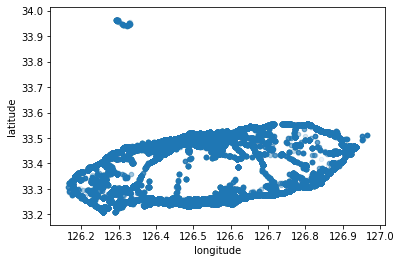

In [47]:
train.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

In [0]:
LABEL_COLUMN = '18~20_ride'

In [49]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [0]:
# Dataset 형태로 csv파일을 변경

def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=5000,
        na_value="?",
        num_epochs=1,
        ignore_errors= True,
        **kwargs)
    return dataset

SELECT_TRAIN_COLUMNS = ['in_out',
                  'latitude', 'longitude', 
                  '6~7_ride', '7~8_ride', '8~9_ride',
                  '9~10_ride', '10~11_ride', '11~12_ride',
                  '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                  '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
                  '18~20_ride']

SELECT_TEST_COLUMNS = ['in_out',
                  'latitude', 'longitude', 
                  '6~7_ride', '7~8_ride', '8~9_ride',
                  '9~10_ride', '10~11_ride', '11~12_ride',
                  '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                  '9~10_takeoff', '10~11_takeoff', '11~12_takeoff']                  

In [0]:
raw_train_data = get_dataset(train_file_path,
                             select_columns = SELECT_TRAIN_COLUMNS,
                             label_name = LABEL_COLUMN)

raw_test_data = get_dataset(test_file_path,
                            select_columns = SELECT_TEST_COLUMNS)

In [0]:
# train set에만 작동 됩니다
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

    print(label)


In [53]:
show_batch(raw_train_data)

in_out              : [b'\xec\x8b\x9c\xeb\x82\xb4' b'\xec\x8b\x9c\xeb\x82\xb4'
 b'\xec\x8b\x9c\xeb\x82\xb4' ... b'\xec\x8b\x9c\xeb\x82\xb4'
 b'\xec\x8b\x9c\xeb\x82\xb4' b'\xec\x8b\x9c\xeb\x82\xb4']
latitude            : [33.4852  33.4923  33.3009  ... 33.51353 33.51315 33.31034]
longitude           : [126.54289 126.5266  126.18043 ... 126.54158 126.52706 126.33932]
6~7_ride            : [0. 2. 2. ... 2. 0. 0.]
7~8_ride            : [0. 0. 2. ... 0. 4. 0.]
8~9_ride            : [0. 0. 1. ... 3. 1. 0.]
9~10_ride           : [1. 0. 0. ... 1. 0. 1.]
10~11_ride          : [1. 0. 1. ... 0. 2. 1.]
11~12_ride          : [0. 0. 2. ... 0. 5. 0.]
6~7_takeoff         : [0. 1. 0. ... 0. 0. 0.]
7~8_takeoff         : [0. 0. 0. ... 0. 1. 0.]
8~9_takeoff         : [0. 0. 0. ... 0. 7. 0.]
9~10_takeoff        : [1. 0. 0. ... 0. 0. 2.]
10~11_takeoff       : [0. 0. 0. ... 0. 4. 1.]
11~12_takeoff       : [0. 0. 0. ... 0. 3. 1.]
tf.Tensor([0. 0. 2. ... 1. 4. 0.], shape=(5000,), dtype=float32)


In [0]:
class PackNumericFeatures(object):
  def __init__(self, names): 
    self.names = names

  # test set에는 label이 없어서 실행이 안될 것임 
  def __call__(self, features, labels):
    numeric_features = [features.pop(name) for name in self.names]
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features, labels

class TestPackNumericFeatures(object):
  def __init__(self, names): 
    self.names = names

  
  def __call__(self, features):
    numeric_features = [features.pop(name) for name in self.names]
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features

In [0]:
NUMERIC_FEATURES = ['latitude', 'longitude', 
                  '6~7_ride', '7~8_ride', '8~9_ride',
                  '9~10_ride', '10~11_ride', '11~12_ride',
                  '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                  '9~10_takeoff', '10~11_takeoff', '11~12_takeoff'
                  ]

packed_train_data = raw_train_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

packed_test_data = raw_test_data.map(
    TestPackNumericFeatures(NUMERIC_FEATURES))

In [56]:
show_batch(packed_train_data)

in_out              : [b'\xec\x8b\x9c\xeb\x82\xb4' b'\xec\x8b\x9c\xeb\x82\xb4'
 b'\xec\x8b\x9c\xeb\x82\xb4' ... b'\xec\x8b\x9c\xeb\x82\xb4'
 b'\xec\x8b\x9c\xeb\x82\xb4' b'\xec\x8b\x9c\xeb\x82\xb4']
numeric             : [[ 33.52121 126.57471   1.      ...   0.        0.        0.     ]
 [ 33.48486 126.54293   0.      ...   1.        2.        0.     ]
 [ 33.51261 126.55096   0.      ...   1.        0.        1.     ]
 ...
 [ 33.24985 126.50723   0.      ...   0.        0.        1.     ]
 [ 33.52023 126.56319   0.      ...   0.        0.        0.     ]
 [ 33.4818  126.48638   0.      ...   0.        0.        0.     ]]
tf.Tensor([2. 0. 1. ... 2. 0. 0.], shape=(5000,), dtype=float32)


In [0]:
example_batch, labels_batch = next(iter(packed_train_data)) 

In [0]:
import numpy as np
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()
desc
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

In [0]:
def normalize_numeric_data(data, mean, std):
  # Center the data
  return (data-mean)/std

In [60]:
# See what you just created.
import functools
normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)

numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
# numeric column을 preprocessing할 정보가 담김 
numeric_column

NumericColumn(key='numeric', shape=(14,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x7f137dcc26a8>, mean=array([3.34203746e+01, 1.26533574e+02, 3.05893030e-01, 8.29698885e-01,
       8.15349656e-01, 6.42475260e-01, 5.99617739e-01, 5.79392571e-01,
       1.12870496e-01, 3.44870168e-01, 5.16480792e-01, 4.30922217e-01,
       4.08001001e-01, 4.02873697e-01]), std=array([0.1079957 , 0.1409865 , 1.10976598, 2.25511606, 2.31756064,
       1.95984392, 1.88594054, 1.94213739, 0.59771422, 1.27917892,
       1.6588497 , 1.48512358, 1.412839  , 1.44608019])))

In [61]:
example_batch['numeric']

<tf.Tensor: shape=(5000, 14), dtype=float32, numpy=
array([[ 33.30452, 126.28862,   0.     , ...,   0.     ,   0.     ,
          2.     ],
       [ 33.51522, 126.50258,   0.     , ...,   0.     ,   0.     ,
          2.     ],
       [ 33.51456, 126.58883,   0.     , ...,   0.     ,   0.     ,
          1.     ],
       ...,
       [ 33.47653, 126.54428,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [ 33.51767, 126.76983,   0.     , ...,   0.     ,   1.     ,
          0.     ],
       [ 33.48997, 126.49127,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)>

In [62]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

array([[-1.072785  , -1.7374498 , -0.27563742, ..., -0.29015914,
        -0.28878096,  1.104452  ],
       [ 0.8782278 , -0.21986665, -0.27563742, ..., -0.29015914,
        -0.28878096,  1.104452  ],
       [ 0.8721169 ,  0.39189622, -0.27563742, ..., -0.29015914,
        -0.28878096,  0.4129275 ],
       ...,
       [ 0.51994985,  0.07592245, -0.27563742, ..., -0.29015914,
        -0.28878096, -0.27859706],
       [ 0.9009049 ,  1.6757053 , -0.27563742, ..., -0.29015914,
         0.41901374, -0.27859706],
       [ 0.64442694, -0.30006415, -0.27563742, ..., -0.29015914,
        -0.28878096, -0.27859706]], dtype=float32)

In [0]:
CATEGORIES = {
    'in_out': ['시내', '시외'],
}

In [0]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
  categorical_columns.append(tf.feature_column.indicator_column(cat_col))

In [65]:
# See what you just created.
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='in_out', vocabulary_list=('시내', '시외'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [66]:
categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

[1. 0.]


In [67]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)
print(preprocessing_layer(example_batch).numpy()[0])


[ 1.          0.         -1.072785   -1.7374498  -0.27563742 -0.3679185
 -0.3518137  -0.32781962 -0.31794095 -0.29832727 -0.18883689 -0.26960275
 -0.31134877 -0.29015914 -0.28878096  1.104452  ]


In [0]:
# rmse를 metrics로 설정하고 싶은 경우 선택합니다.
def rmse(targets, predictions):
  rmse = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(targets, predictions)))
  return rmse

In [0]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mse', 'mae', rmse])

In [0]:
train_data = packed_train_data.shuffle(500)

In [71]:
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
# 이 부분은 개별적으로 공부해보세요
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(train_data, steps_per_epoch= 1000, epochs=20)


Train for 1000 steps
Epoch 1/20
  84/1000 [=>............................] - ETA: 1:33 - loss: 14.1734 - mse: 14.1533 - mae: 1.2949 - rmse: 3.6472

In [72]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

loss       mse       mae     rmse  epoch
0  14.153311  14.15331  1.294857  3.64717      0

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


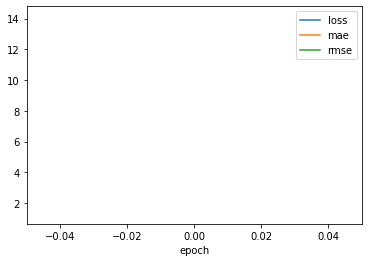

In [73]:
hist.drop('mse', axis = 1).plot(kind = 'line', x = 'epoch')

In [0]:
test_data = packed_test_data
predictions = model.predict(test_data)

In [75]:
predictions.shape

(228170, 1)

In [0]:
submission = pd.read_csv(submission_path)

In [77]:
submission['18~20_ride'] = predictions
submission.head()

id  18~20_ride
0  415423    0.417005
1  415424    1.006335
2  415425    0.310545
3  415426    0.628893
4  415427    2.274790

In [0]:
submission.to_csv('/content/submit.csv', index = False)